# Modelling the close price with SARIMAX

## Imports and data

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

Load datasets

In [3]:
monthly_M2_SP = pd.read_csv(r'C:\Users\swift5\WEC2023\monthly_M2_SP.csv')
monthly_M2_SP['Date'] =  pd.to_datetime(monthly_M2_SP['Date'],  format='%Y-%m-%d')
monthly_M2_SP.set_index('Date', inplace=True)
monthly_M2_SP
#monthly_M2_SP.index = pd.date_range(start=monthly_M2_SP.index.min(), end=monthly_M2_SP.index.max(), freq='M')
#print(monthly_M2_SP.index.freq)

,Open,High,Low,Close,Volume,M2NS
Date,,,,,,
1980-11-01,127.47,141.96,127.23,140.52,5.489500e+08,1599.0
1980-12-01,140.52,140.66,125.32,135.76,5.698056e+08,1604.8
1981-01-01,135.76,140.32,128.57,129.55,5.308444e+08,1610.6
1981-02-01,129.48,132.02,124.66,131.27,4.535056e+08,1610.5
1981-03-01,131.27,138.38,128.56,136.00,6.525167e+08,1633.2
...,...,...,...,...,...,...
2022-10-01,3609.78,3905.42,3491.58,3871.98,5.678654e+10,21380.1
2022-11-01,3901.79,4080.11,3698.15,4080.11,5.230904e+10,21378.7
2022-12-01,4087.14,4100.96,3764.49,3839.50,4.845613e+10,21400.0


# Seasonality

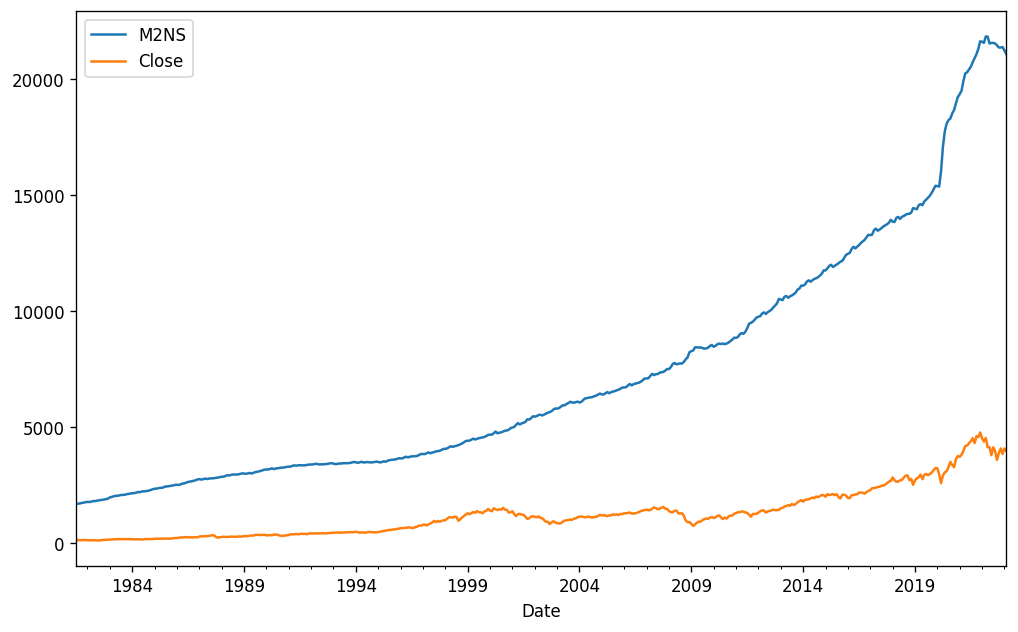

In [49]:
monthly_M2_SP['M2NS'].plot()
monthly_M2_SP['Close'].plot()
plt.legend(['M2NS','Close'])
plt.savefig('SP_M2_month.png')

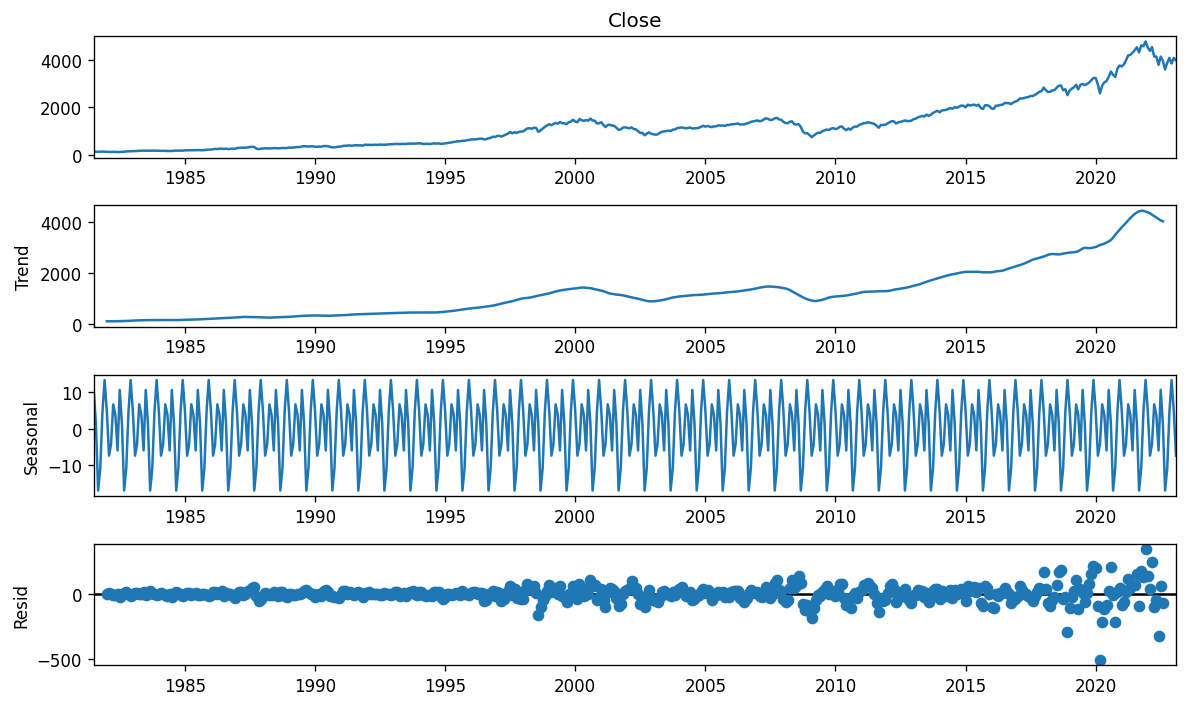

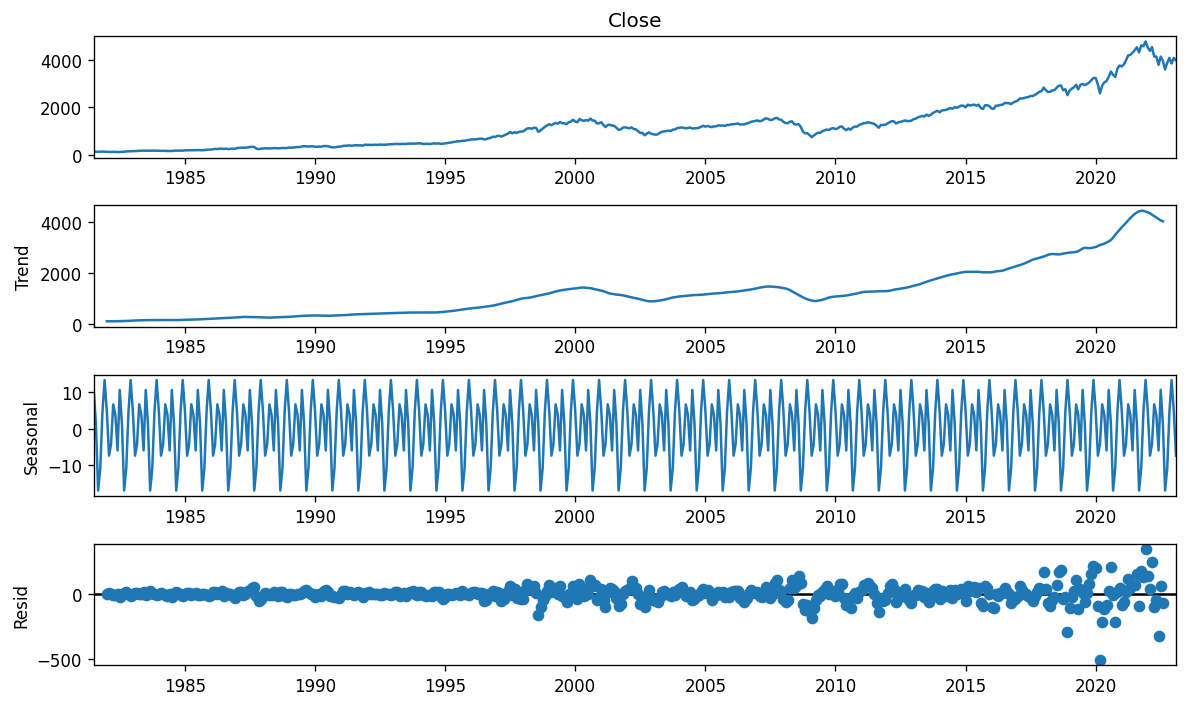

In [48]:
display(sm.tsa.seasonal_decompose(monthly_M2_SP['Close'],model='additive').plot())
plt.savefig('decomposition_month_sarimax.png')
#display(sm.tsa.seasonal_decompose(monthly_M2_SP['M2NS'],model='additive').plot())
# sm.tsa.seasonal_decompose(monthly_M2_SP['Close'],model='additive').seasonal.plot()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

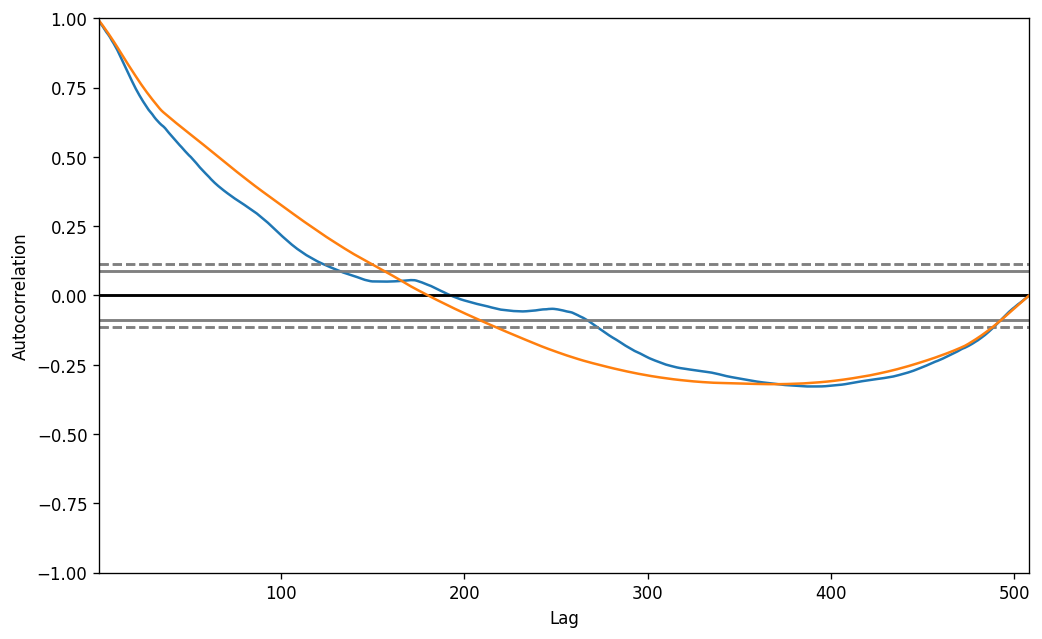

In [6]:
# Test for seasonality
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
autocorrelation_plot(monthly_M2_SP['Close'].tolist())
autocorrelation_plot(monthly_M2_SP['M2NS'].tolist())

# Stationarity and test for no White Noise

## Imports

In [7]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [8]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

## Close series

In [9]:
adf_test(monthly_M2_SP['Close'])
kpss_test(monthly_M2_SP['Close'])

adf_test(monthly_M2_SP['M2NS'])
kpss_test(monthly_M2_SP['M2NS'])

Results of Dickey-Fuller Test:
Test Statistic                   2.359955
p-value                          0.998990
#Lags Used                      14.000000
Number of Observations Used    493.000000
Critical Value (1%)             -3.443684
Critical Value (5%)             -2.867420
Critical Value (10%)            -2.569902
dtype: float64
Results of KPSS Test:
Test Statistic            2.957411
p-value                   0.010000
Lags Used                13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   2.094424
p-value                          0.998784
#Lags Used                      17.000000
Number of Observations Used    490.000000
Critical Value (1%)             -3.443766
Critical Value (5%)             -2.867457
Critical Value (10%)            -2.569921
dtype: float64
Results of KPSS Test:
Test Statistic  

c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Basic series non-stationary

### Log and diff

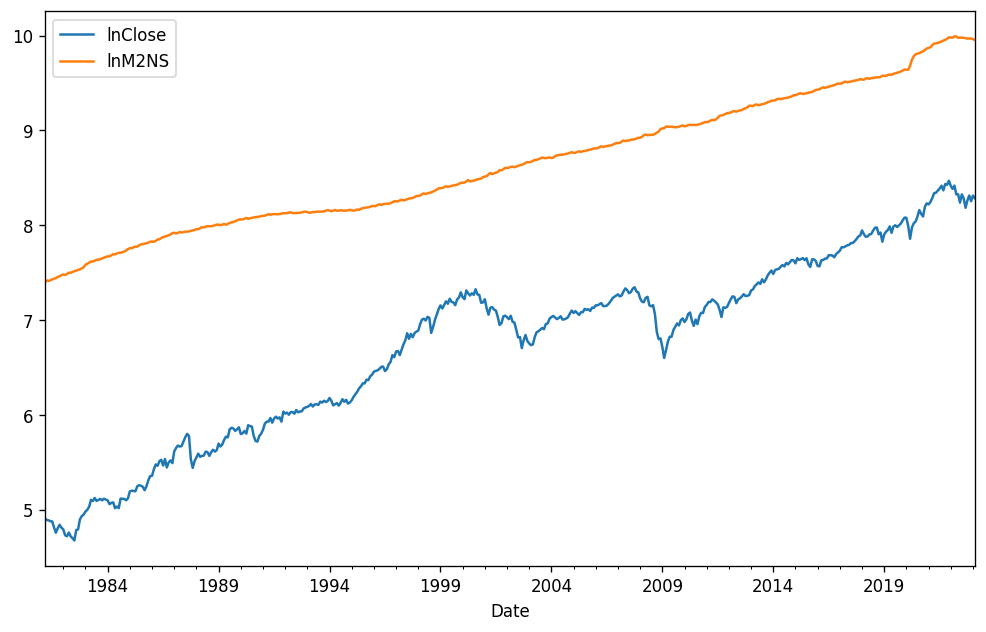

In [39]:
monthly_M2_SP['lnClose'] = np.log(monthly_M2_SP['Close'])
monthly_M2_SP.dropna(inplace=True)
monthly_M2_SP['lnM2NS'] = np.log(monthly_M2_SP['M2NS'])
monthly_M2_SP.dropna(inplace=True)
monthly_M2_SP['lnClose'].plot()
monthly_M2_SP['lnM2NS'].plot()
plt.legend(['lnClose','lnM2NS'])

In [11]:
adf_test(monthly_M2_SP['lnClose'])
kpss_test(monthly_M2_SP['lnClose'])
adf_test(monthly_M2_SP['lnM2NS'])
kpss_test(monthly_M2_SP['lnM2NS'])

Results of Dickey-Fuller Test:
Test Statistic                  -0.857580
p-value                          0.801621
#Lags Used                       0.000000
Number of Observations Used    507.000000
Critical Value (1%)             -3.443314
Critical Value (5%)             -2.867258
Critical Value (10%)            -2.569815
dtype: float64
Results of KPSS Test:
Test Statistic            3.415054
p-value                   0.010000
Lags Used                13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   0.103042
p-value                          0.966268
#Lags Used                      17.000000
Number of Observations Used    490.000000
Critical Value (1%)             -3.443766
Critical Value (5%)             -2.867457
Critical Value (10%)            -2.569921
dtype: float64
Results of KPSS Test:
Test Statistic  

c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Both tests show non-stationarity

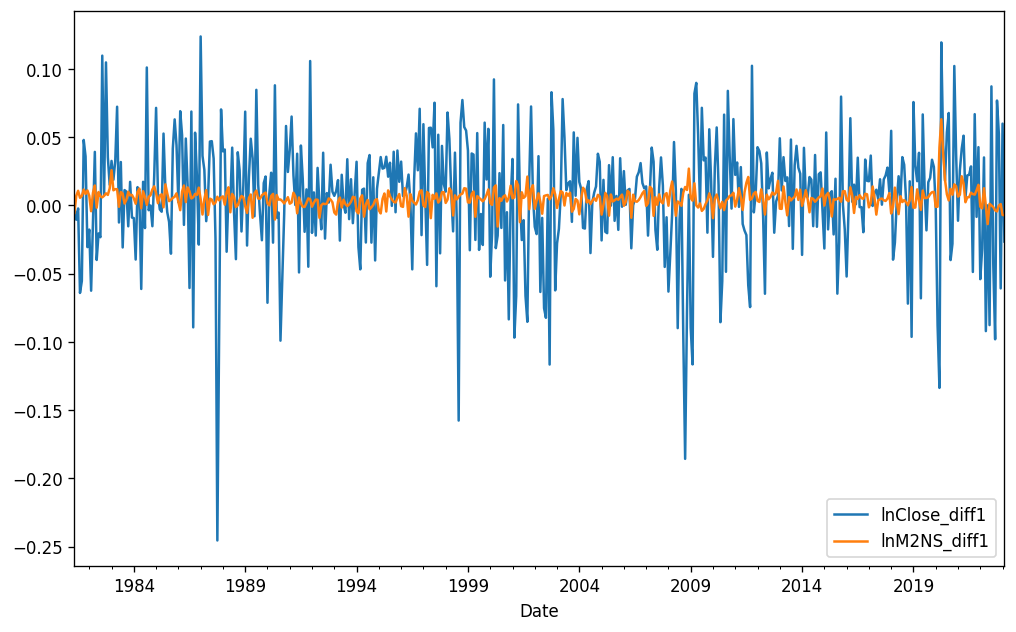

In [40]:
monthly_M2_SP['lnClose_diff1'] = monthly_M2_SP['lnClose']- monthly_M2_SP['lnClose'].shift(1)
monthly_M2_SP.dropna(inplace=True)
monthly_M2_SP['lnM2NS_diff1'] = monthly_M2_SP['lnM2NS']- monthly_M2_SP['lnM2NS'].shift(1)
monthly_M2_SP.dropna(inplace=True)
monthly_M2_SP['lnClose_diff1'].plot()
monthly_M2_SP['lnM2NS_diff1'].plot()
plt.legend(['lnClose_diff1','lnM2NS_diff1'])

In [13]:
adf_test(monthly_M2_SP['lnClose_diff1'])
kpss_test(monthly_M2_SP['lnClose_diff1'])
adf_test(monthly_M2_SP['lnM2NS_diff1'])
kpss_test(monthly_M2_SP['lnM2NS_diff1'])

Results of Dickey-Fuller Test:
Test Statistic                 -22.128835
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    505.000000
Critical Value (1%)             -3.443366
Critical Value (5%)             -2.867280
Critical Value (10%)            -2.569827
dtype: float64
Results of KPSS Test:
Test Statistic           0.084875
p-value                  0.100000
Lags Used                1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -3.981157
p-value                          0.001512
#Lags Used                      16.000000
Number of Observations Used    489.000000
Critical Value (1%)             -3.443794
Critical Value (5%)             -2.867469
Critical Value (10%)            -2.569928
dtype: float64
Results of KPSS Test:
Test Statistic         

c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Both tests show stationarity

### Diff once

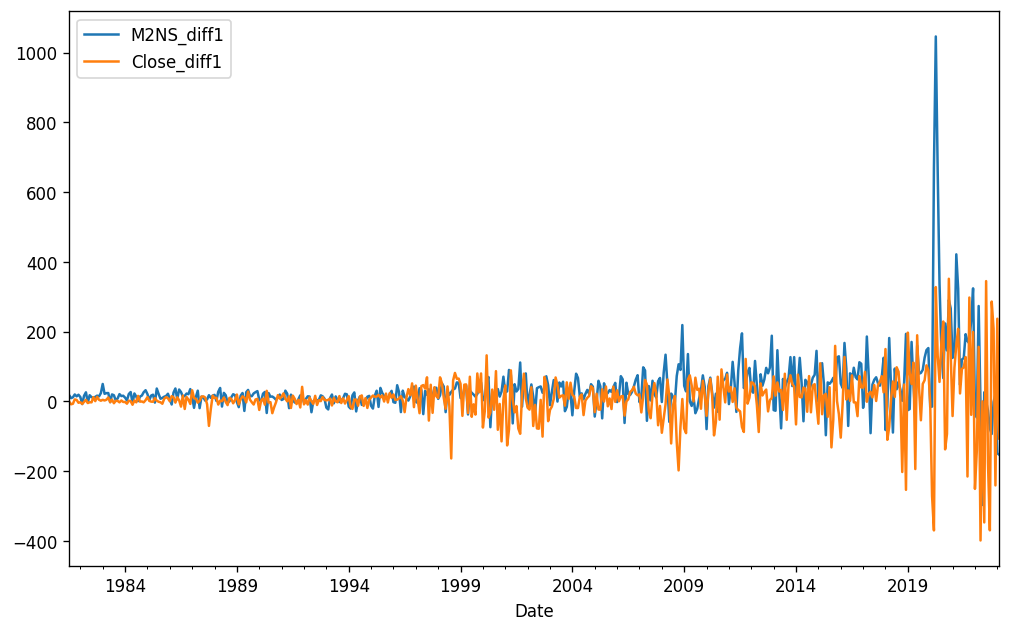

In [47]:
monthly_M2_SP['Close_diff1'] = monthly_M2_SP['Close']- monthly_M2_SP['Close'].shift(1)
monthly_M2_SP.dropna(inplace=True)
monthly_M2_SP['M2NS_diff1'] = monthly_M2_SP['M2NS']- monthly_M2_SP['M2NS'].shift(1)
monthly_M2_SP.dropna(inplace=True)
monthly_M2_SP['M2NS_diff1'].plot()
monthly_M2_SP['Close_diff1'].plot()
plt.legend(['M2NS_diff1','Close_diff1'])
plt.savefig('diff1_month_sarimax.png')

In [15]:
#stationary
adf_test(monthly_M2_SP['Close_diff1'])
kpss_test(monthly_M2_SP['Close_diff1'])
adf_test(monthly_M2_SP['M2NS_diff1'])
kpss_test(monthly_M2_SP['M2NS_diff1'])

Results of Dickey-Fuller Test:
Test Statistic                -5.931091e+00
p-value                        2.379683e-07
#Lags Used                     1.400000e+01
Number of Observations Used    4.890000e+02
Critical Value (1%)           -3.443794e+00
Critical Value (5%)           -2.867469e+00
Critical Value (10%)          -2.569928e+00
dtype: float64
Results of KPSS Test:
Test Statistic           0.373929
p-value                  0.088393
Lags Used                1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -3.643347
p-value                          0.004984
#Lags Used                      16.000000
Number of Observations Used    487.000000
Critical Value (1%)             -3.443849
Critical Value (5%)             -2.867493
Critical Value (10%)            -2.569941
dtype: float64
Results of KPSS Test:
Test Stat

c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### White noise test Ljung-Box

In [16]:
sm.stats.acorr_ljungbox(monthly_M2_SP['lnClose_diff1'], lags=range(1,12), return_df=True)

,lb_stat,lb_pvalue
1,0.106512,0.744151
2,0.914848,0.632912
3,1.443835,0.695293
4,1.446218,0.836124
5,3.387862,0.640419
6,4.907135,0.555778
7,6.476588,0.485327
8,6.567373,0.583945
9,8.453297,0.489187
10,9.368824,0.497495


Base series non-stationary

# SARIMAX

In [17]:
#splitting the data to train and test sets (test for 12 weeks)
train = monthly_M2_SP.iloc[:-12]
test = monthly_M2_SP.iloc[-12:]

## Choosing p and q

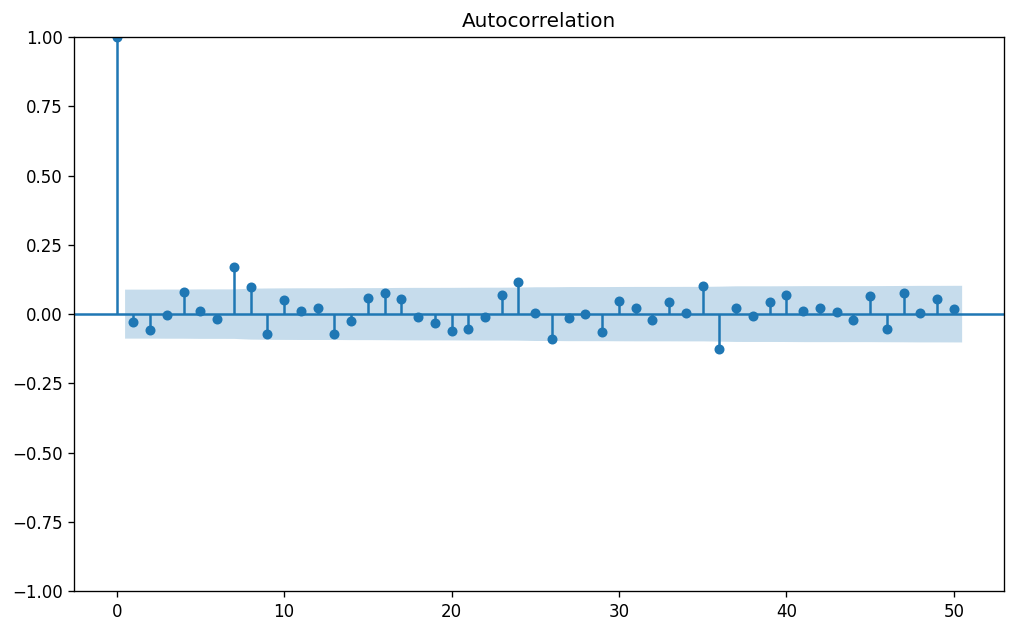

In [46]:
sm.graphics.tsa.plot_acf(train["Close_diff1"].values.squeeze(), lags=50)
plt.savefig('autocorr_month_sarimax.png')
#sm.graphics.tsa.plot_pacf(train["M2NS_diff1"].values.squeeze(), lags=50, method="ywm")

Box-Jenkins p=2 q=3

## Model choice

In [19]:
import itertools

In [29]:

p = range(0,3)
q = range(0,2)
# for already differentiated series
d = [0]
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (1, 0, 0, 12)
SARIMAX: (1, 0, 0) x (1, 0, 1, 12)
SARIMAX: (1, 0, 0) x (2, 0, 0, 12)


In [31]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(endog=train['Close_diff1'],
                                            exog =train['M2NS_diff1'],\
                                            trend='n',\
                                            order=param,\
                                            seasonal_order=param_seasonal)

            results = mod.fit()

            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:5472.75496341394


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:5474.752351503807
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:5474.751757856486


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:5466.224961455768


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 0)x(2, 0, 0, 12)12 - AIC:5469.144481640842


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 0)x(2, 0, 1, 12)12 - AIC:5458.649298669359


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:5473.568024943697


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5475.527453909699


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:5475.518068927483


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:5466.406008163593


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 1)x(2, 0, 0, 12)12 - AIC:5469.800461728453


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 1)x(2, 0, 1, 12)12 - AIC:5459.633093401541
SARIMAX(1, 0, 0)x(0, 0, 0, 12)12 - AIC:5473.685957274531


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 0)x(0, 0, 1, 12)12 - AIC:5475.651167485476


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 0)x(1, 0, 0, 12)12 - AIC:5475.643109585746


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 0)x(1, 0, 1, 12)12 - AIC:5466.5627947919675


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 0)x(2, 0, 0, 12)12 - AIC:5469.876212252362


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 0)x(2, 0, 1, 12)12 - AIC:5459.692363199169


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 1)x(0, 0, 0, 12)12 - AIC:5474.719210249708


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 1)x(0, 0, 1, 12)12 - AIC:5476.688474057644


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 1)x(1, 0, 0, 12)12 - AIC:5476.679712697048


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 1)x(1, 0, 1, 12)12 - AIC:5469.4104870244455


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 1)x(2, 0, 0, 12)12 - AIC:5471.528130268086


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 1)x(2, 0, 1, 12)12 - AIC:5461.405809808864
SARIMAX(2, 0, 0)x(0, 0, 0, 12)12 - AIC:5474.437916179738


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(2, 0, 0)x(0, 0, 1, 12)12 - AIC:5476.403356764429


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(2, 0, 0)x(1, 0, 0, 12)12 - AIC:5476.395829096144


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(2, 0, 0)x(1, 0, 1, 12)12 - AIC:5467.581235227316


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(2, 0, 0)x(2, 0, 0, 12)12 - AIC:5471.454370415329


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(2, 0, 0)x(2, 0, 1, 12)12 - AIC:5461.242297901281


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(2, 0, 1)x(0, 0, 0, 12)12 - AIC:5476.363870482665


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(2, 0, 1)x(0, 0, 1, 12)12 - AIC:5478.320654093042


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(2, 0, 1)x(1, 0, 0, 12)12 - AIC:5478.31966489745


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(2, 0, 1)x(1, 0, 1, 12)12 - AIC:5469.540019319473


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(2, 0, 1)x(2, 0, 0, 12)12 - AIC:5473.422446844994


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX(2, 0, 1)x(2, 0, 1, 12)12 - AIC:5463.2353631595015


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Figure size 1200x720 with 0 Axes>

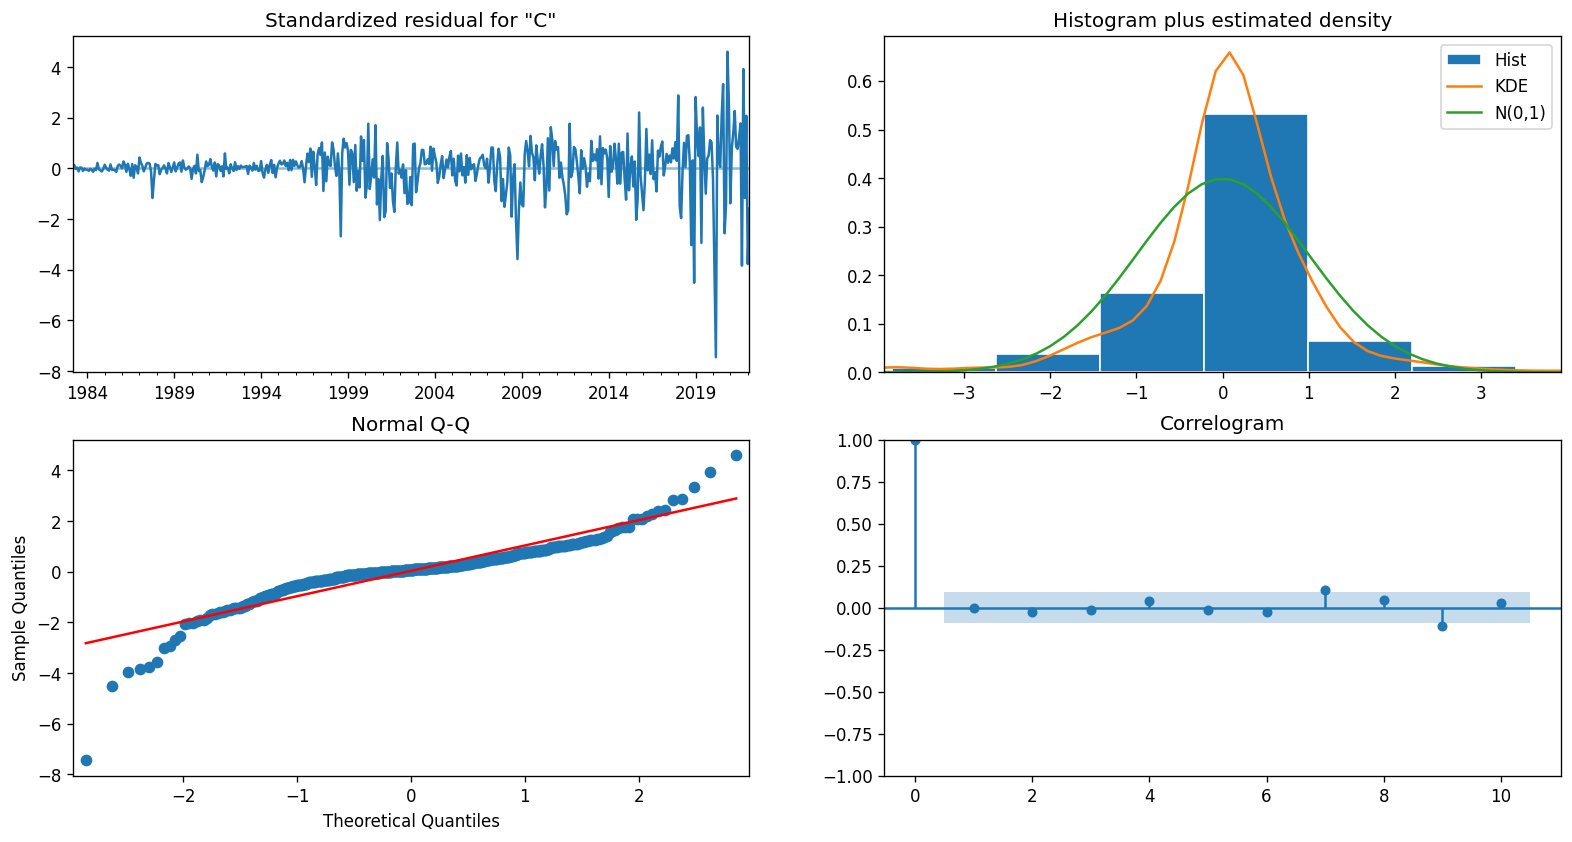

<Figure size 1200x720 with 0 Axes>

In [53]:
#lowest AIC: SARIMAX(0, 0, 1)x(2, 0, 0, 12)12 - AIC:5469.80046172845
plt.tight_layout()
mod = sm.tsa.statespace.SARIMAX(endog=train['Close_diff1'],
                                exog =train['M2NS_diff1'],\
                                order=(0, 0, 1),
                                seasonal_order=(2, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

results.plot_diagnostics(figsize=(16, 8))
plt.show()
plt.savefig('diagnostic_month_sarimax.png')

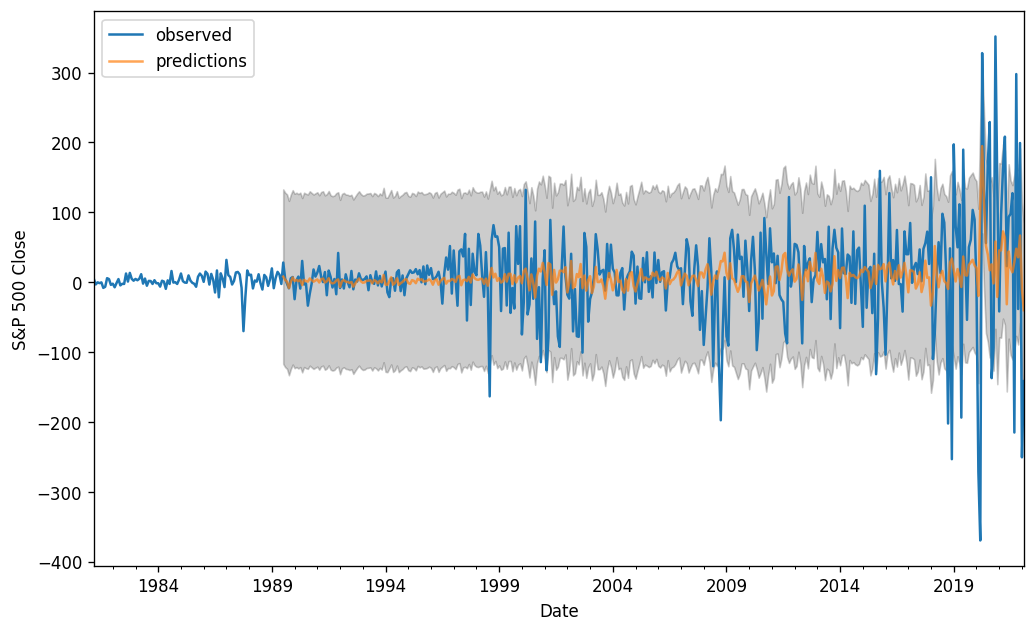

In [44]:
start_forecast = 100
pred = results.get_prediction(start=start_forecast, dynamic=False)
pred_ci = pred.conf_int()

ax = train['Close_diff1'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='predictions', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('S&P 500 Close')
plt.legend()
plt.savefig('forecast_month_in_sarimax.png')
plt.show()

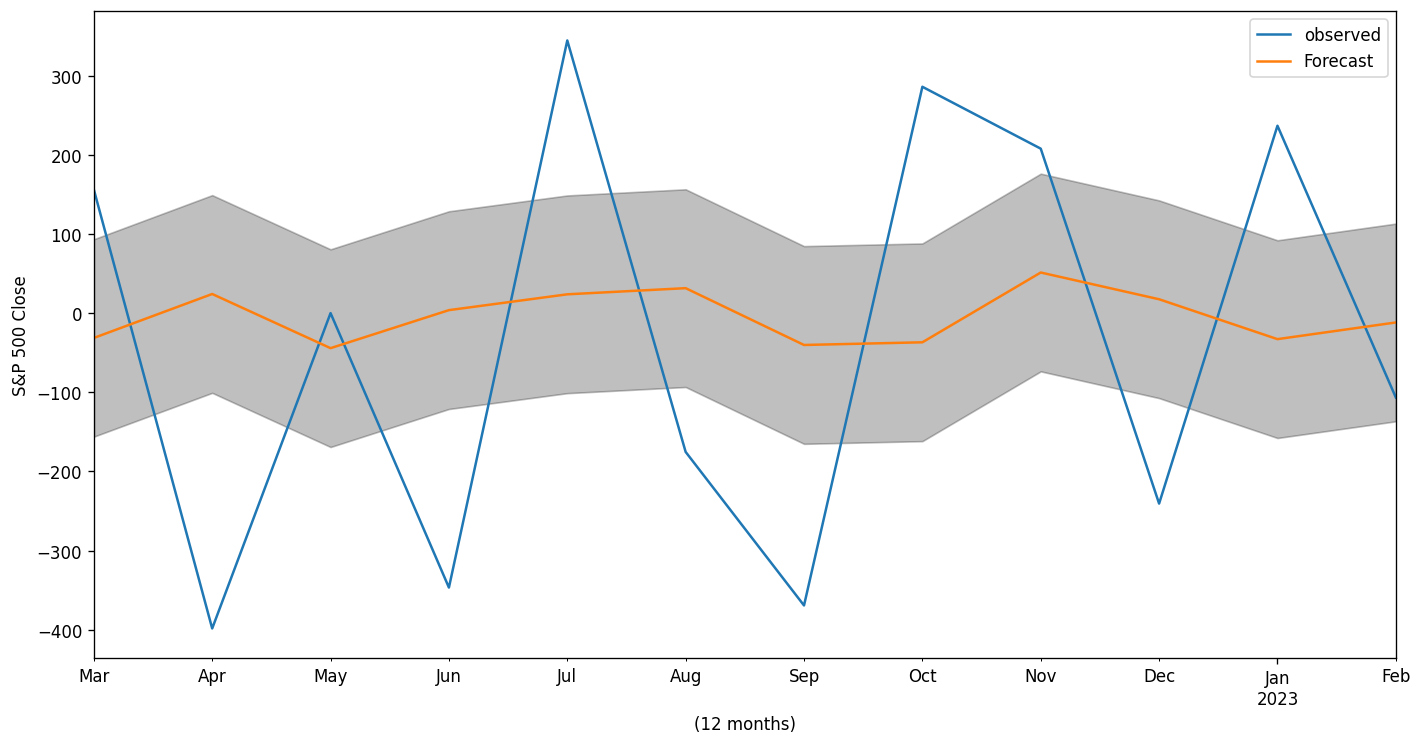

In [52]:
#%% Forecast 1y
import os

pred_uc = results.get_forecast(steps=12, exog=test['M2NS_diff1']) #12 weeks
pred_ci = pred_uc.conf_int()
ax = test['Close_diff1'].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('(12 months)')
ax.set_ylabel('S&P 500 Close')
plt.legend()
plt.show() 
plt.savefig('forecast_month_sarimax.jpg')
plt.close()


In [50]:
#!pip install scikit-learn

from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = test['Close']

y_pred = [train['Close'][-1] + pred_uc.predicted_mean[0]]

for diff in pred_uc.predicted_mean[1:]:
    pred_value = y_pred[-1] + diff
    y_pred.append(pred_value)

def MAPE(y_true,y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true)) * 100

print("MAPE: ", MAPE(y_true, y_pred))
print("MSE: ", mean_squared_error(y_true, y_pred))
print("MAE: ",mean_absolute_error(y_true, y_pred))
for table in results.summary().tables:
    print('#################################################')
    print(table.as_latex_tabular())
    print(table)

MAPE:  9.46725270392405
MSE:  164862.85240259665
MAE:  369.5624777836638
#################################################
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}   &           Close\_diff1          & \textbf{  No. Observations:  } &    492     \\
\textbf{Model:}           & SARIMAX(0, 0, 1)x(2, 0, [], 12) & \textbf{  Log Likelihood     } & -2608.048  \\
\textbf{Date:}            &         Sun, 23 Apr 2023        & \textbf{  AIC                } &  5226.096  \\
\textbf{Time:}            &             03:31:21            & \textbf{  BIC                } &  5246.839  \\
\textbf{Sample:}          &            03-01-1981           & \textbf{  HQIC               } &  5234.258  \\
\textbf{}                 &           - 02-01-2022          & \textbf{                     } &            \\
\textbf{Covariance Type:} &               opg               & \textbf{                     } &            \\
\bottomrule
\end{tabular}
%\caption{SARIMAX Results}
\end{center}
  